In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
plt.style.use('classic')

In [58]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [59]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
dataset_dir = "/content/drive/MyDrive/Feynn_Labs_Internship/Portfolio_Managment"

In [61]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the stock ticker and the date range
ticker = 'F'
start_date = '2001-01-01'
end_date = '2019-01-30'

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate Log Returns
data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Calculate Exponential Moving Average (EMA)
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['RSI'] = RSI(data['Close'])

# Calculate Bollinger Bands
data['Middle Band'] = data['Close'].rolling(window=20).mean()
data['Upper Band'] = data['Middle Band'] + (data['Close'].rolling(window=20).std() * 2)
data['Lower Band'] = data['Middle Band'] - (data['Close'].rolling(window=20).std() * 2)

# Calculate MACD
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Select the top features
selected_features = data[['Log Returns','Volume','EMA_10', 'RSI', 'Middle Band', 'Upper Band', 'Lower Band', 'MACD', 'MACD Signal']]

[*********************100%%**********************]  1 of 1 completed


In [62]:
assets = selected_features.dropna()

In [63]:
assets

,Log Returns,Volume,EMA_10,RSI,Middle Band,Upper Band,Lower Band,MACD,MACD Signal
Date,,,,,,,,,
2001-01-30,0.000353,4020200,27.582715,65.553232,26.813875,28.885035,24.742715,0.855295,0.737934
2001-01-31,-0.003894,4553600,27.693131,66.412870,27.007750,28.800201,25.215299,0.852822,0.760911
2001-02-01,0.006365,3507100,27.816198,63.257763,27.170000,28.827244,25.512757,0.855524,0.779834
2001-02-02,-0.012771,4275600,27.851435,65.721160,27.223625,28.918180,25.529071,0.819174,0.787702
2001-02-05,0.015587,4061600,27.960265,63.548067,27.333625,29.047577,25.619673,0.816459,0.793453
...,...,...,...,...,...,...,...,...,...
2019-01-23,-0.019003,45196900,8.471619,58.270680,8.266000,9.118523,7.413477,-0.009335,-0.044490
2019-01-24,0.030699,79516400,8.494961,64.642862,8.314500,9.123957,7.505043,0.002376,-0.035117
2019-01-25,0.029784,53098800,8.561332,64.130434,8.365000,9.178453,7.551547,0.032265,-0.021641


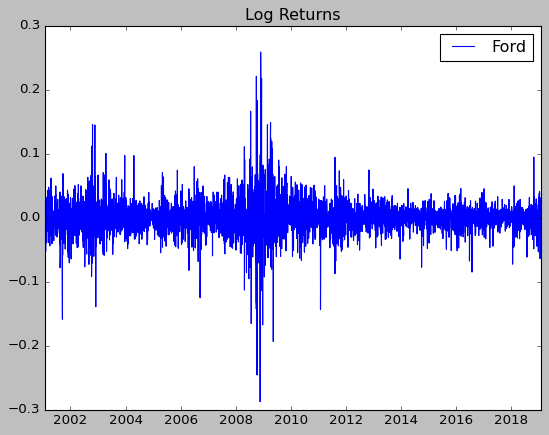

In [30]:
# Plot log returns for visual inspection
plt.plot(assets['Log Returns'], label='Ford')
plt.legend()
plt.title('Log Returns')
plt.show()

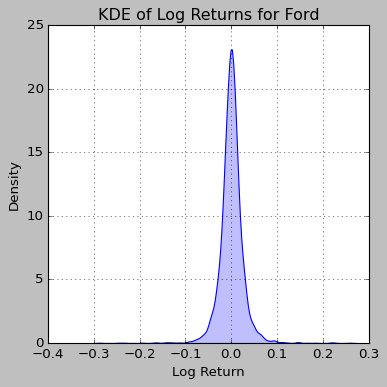

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the subplots for KDE plots
fig, axes = plt.subplots(figsize=(5, 5))

# Plot KDE for each stock
sns.kdeplot(assets['Log Returns'], ax=axes, fill=True)
axes.set_title(f'KDE of Log Returns for {"Ford"}')
axes.set_xlabel('Log Return')
axes.set_ylabel('Density')
axes.grid(True)

# Remove the empty subplot if the number of plots is less than the number of subplots

# Adjust layout for better display
plt.tight_layout()
plt.show()

In [65]:

# Create a dataframe for each stock with log returns and lagged returns
def create_lagged_returns():
    data = pd.DataFrame(assets)
    data.index = pd.to_datetime(data.index)
    for lag in range(1, 101):
        data[f'Returns_Lag_{lag}'] = data['Log Returns'].shift(lag)
        # data[f'Returns_Volume_{lag}'] = data['Volume'].shift(lag)
        # data[f'Returns_EMA_{lag}'] = data['EMA_10'].shift(lag)
        # data[f'Returns_RSI_{lag}'] = data['RSI'].shift(lag)
        # data[f'Returns_MACD_{lag}'] = data['MACD'].shift(lag)
    data.dropna(inplace=True)
    return data

data = create_lagged_returns()
data.drop(columns = ["Volume","EMA_10","RSI","Middle Band","Upper Band","Lower Band",	"MACD","MACD Signal"], inplace = True)


<ipython-input-65-b4df5c9e0aab>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Returns_Lag_{lag}'] = data['Log Returns'].shift(lag)
<ipython-input-65-b4df5c9e0aab>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Returns_Lag_{lag}'] = data['Log Returns'].shift(lag)
<ipython-input-65-b4df5c9e0aab>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [66]:
# Standardize returns
scaler = StandardScaler()
data.iloc[:,0:] = scaler.fit_transform(data.iloc[:,0:])

In [67]:
def split_data(data):
    train_size = int(0.7 * len(data))
    val_size = int(0.1 * len(data))
    train = data.iloc[:train_size]
    val = data.iloc[train_size:train_size + val_size]
    test = data.iloc[train_size + val_size:]
    return train, val, test

split_data = split_data(data)

In [68]:
from sklearn.neural_network import BernoulliRBM

# Apply RBM to the lagged returns
rbm = BernoulliRBM(n_components=100, learning_rate=0.005, n_iter=20, random_state=10)

rbm_transformed_data = {}
train = split_data[0]
val = split_data[1]
test = split_data[2]
X_train = np.asarray(train.iloc[:, 1:]).reshape(-1,2)

rbm_pipeline = Pipeline(steps=[('rbm', rbm)])
# X_train_transformed = rbm_pipeline.fit_transform(X_train)
X_train_transformed = X_train
# X_val_transformed = rbm_pipeline.transform(np.asarray(val.iloc[:, 1:]).reshape(-1,5))
X_val_transformed = np.asarray(val.iloc[:, 1:]).reshape(-1,1)
# X_test_transformed = rbm_pipeline.transform(np.asarray(test.iloc[:, 1:]).reshape(-1,5))
X_test_transformed = np.asarray(test.iloc[:, 1:]).reshape(-1,1)
rbm_transformed_data = (X_train_transformed.reshape(-1,100,1), np.asarray(train['Log Returns']).reshape(-1,1), X_val_transformed.reshape(-1,100,1), np.asarray(val['Log Returns']).reshape(-1,1), X_test_transformed.reshape(-1,100,1), np.asarray(test['Log Returns']).reshape(-1,1))

In [37]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


In [39]:
import tensorflow as tf

# Define LSTM model
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units_lstm_1', min_value=64, max_value=128, step=32),
        return_sequences=True,
        input_shape=input_shape,
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2_lstm_1', values=[0.0001, 0.0005, 0.001]))
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(LSTM(
        units=hp.Int('units_lstm_2', min_value=32, max_value=64, step=32),
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2_lstm_2', values=[0.0001, 0.0005, 0.001]))
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(LSTM(
        units=hp.Int('units_lstm_3', min_value=16, max_value=32, step=16),
        kernel_regularizer=tf.keras.regularizers.L2(hp.Choice('l2_lstm_3', values=[0.0001, 0.0005, 0.001]))
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
    )
    return model


input_shape = (50, 2)  # Adjust according to RBM output

X_train = rbm_transformed_data[0]
y_train = rbm_transformed_data[1]
X_val = rbm_transformed_data[2]
y_val = rbm_transformed_data[3]
X_test = rbm_transformed_data[4]
y_test = rbm_transformed_data[5]


tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='lstm_stock_prediction'
)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=50,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Trial 20 Complete [00h 02m 27s]
val_loss: 0.2641381174325943

Best val_loss So Far: 0.24030739068984985
Total elapsed time: 00h 35m 30s


In [41]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
model.summary()

model.fit(X_train, y_train,
          epochs=50,
          validation_data=(X_val, y_val),
          callbacks=[ModelCheckpoint('best_model.keras', save_best_only=True), EarlyStopping(monitor='val_loss', patience=10)])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 50, 32)              │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 96)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,233 (356.38 KB)

 Trainable params: 91,233 (356.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.2327 - val_loss: 0.2478
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2337 - val_loss: 0.2451
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2547 - val_loss: 0.2406
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3515 - val_loss: 0.2418
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1468 - val_loss: 0.2419
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2962 - val_loss: 0.2405
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2191 - val_loss: 0.2411
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5106 - val_loss: 0.2404
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2511 - val_loss: 0.2408
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3785 - val_loss: 0.8530
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2735 - val_loss: 1.2640
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2

In [43]:
#test the best model
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the best model
best_model = load_model('best_model.keras')

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Mean Squared Error (MSE) on test data: {mse}')
print(f'R^2 Score on test data: {r2}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Mean Squared Error (MSE) on test data: 0.37326589759773315
R^2 Score on test data: -0.03560968549725274


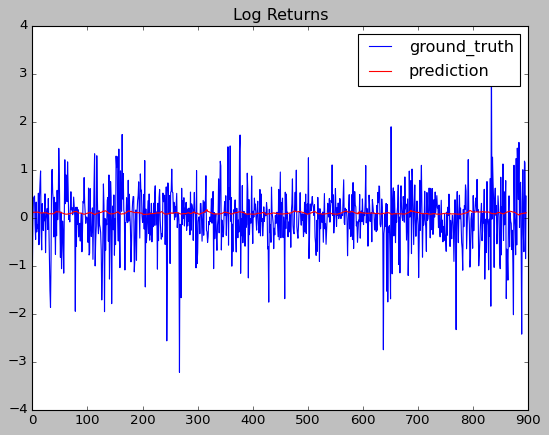

In [44]:
# Plot log returns for visual inspection
plt.plot(y_test, label='ground_truth', color = 'blue')
plt.plot(y_pred, label = "prediction", color = 'red')
plt.legend()
plt.title('Log Returns')
plt.show()

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


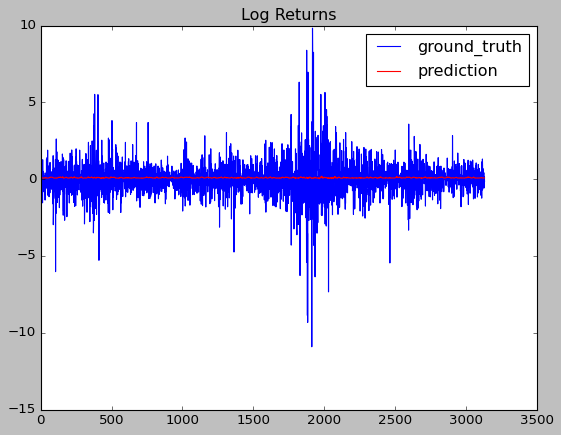

In [47]:
# Plot log returns for visual inspection
plt.plot(y_train, label='ground_truth', color = 'blue')
plt.plot(model.predict(X_train), label = "prediction", color = 'red')
plt.legend()
plt.title('Log Returns')
plt.show()